<a href="https://colab.research.google.com/github/DenuraTHEbest/InvestHere/blob/Amna_S/aspiFinal2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta

In [ ]:
import pandas as pd
from google.colab import drive
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import joblib
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands

# Mount Google Drive
drive.mount('/content/drive')

# Load datasets
aspi_data = pd.read_csv('/content/drive/My Drive/CSE_All_Share_Historical_Data_Processed.csv')
sentiment_data = pd.read_csv('/content/drive/My Drive/daily_weighted_scores_9-12.csv')

# Convert the Date columns to pandas datetime for both datasets
aspi_data['Date'] = pd.to_datetime(aspi_data['Date'])  # Already in YYYY-MM-DD format
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])  # Already in YYYY-MM-DD format

# Filter for the common date range
common_start_date = max(aspi_data['Date'].min(), sentiment_data['Date'].min())
common_end_date = min(aspi_data['Date'].max(), sentiment_data['Date'].max())

aspi_data = aspi_data[(aspi_data['Date'] >= common_start_date) & (aspi_data['Date'] <= common_end_date)]
sentiment_data = sentiment_data[(sentiment_data['Date'] >= common_start_date) & (sentiment_data['Date'] <= common_end_date)]

# Sort both datasets by date in ascending order
aspi_data = aspi_data.sort_values(by='Date')
sentiment_data = sentiment_data.sort_values(by='Date')

# Merge datasets with lagged sentiment features
for lag in range(1, 10):  # 9 days lag
    sentiment_data[f'Lagged_Sentiment_{lag}'] = sentiment_data['Weighted_Sentiment'].shift(lag)

# Drop rows with NaN values introduced by shifting
sentiment_data = sentiment_data.dropna(subset=[f'Lagged_Sentiment_{lag}' for lag in range(1, 10)])

# Merge the sentiment data with the ASPI data
merged_data = pd.merge(aspi_data[['Date', 'Price']], sentiment_data[['Date', 'Weighted_Sentiment'] + [f'Lagged_Sentiment_{lag}' for lag in range(1, 10)]],
                       on='Date', how='left')

# Create lagged price features (10, 20, 30 days)
for lag in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 18, 20, 25, 30]:
    merged_data[f'Price_Lag{lag}'] = merged_data['Price'].shift(lag)

# Calculate EMAs with different spans
merged_data['EMA_7'] = merged_data['Price'].ewm(span=7, adjust=False).mean()
merged_data['EMA_14'] = merged_data['Price'].ewm(span=14, adjust=False).mean()
merged_data['EMA_30'] = merged_data['Price'].ewm(span=30, adjust=False).mean()

# Calculate RSI with a 14-day window
#rsi = RSIIndicator(merged_data['Price'], window=14)
#merged_data['RSI_14'] = rsi.rsi()

# Drop rows with NaN values (from shifting and moving averages)
merged_data = merged_data.dropna()

# Create target variables for the next 20 days
for i in range(1, 21):
    merged_data[f'Target_{i}'] = merged_data['Price'].shift(-i)

# Remove rows with NaN values (from shifting)
merged_data = merged_data.dropna()

# Convert Date to numerical format (Unix timestamp)
merged_data['Date'] = merged_data['Date'].astype(np.int64) // 10**9  # Convert to Unix timestamp

# Compute MACD using 12, 26, and 9-day EMAs (default settings)
macd = MACD(merged_data['Price'])

# Add MACD components as features
merged_data['MACD'] = macd.macd()
merged_data['MACD_Signal'] = macd.macd_signal()
merged_data['MACD_Histogram'] = macd.macd_diff()

# Calculate Bollinger Bands with a 20-day window
bollinger = BollingerBands(merged_data['Price'], window=20, window_dev=2)

# Add Bollinger Bands features
merged_data['Bollinger_High'] = bollinger.bollinger_hband()
merged_data['Bollinger_Low'] = bollinger.bollinger_lband()
merged_data['Bollinger_Width'] = merged_data['Bollinger_High'] - merged_data['Bollinger_Low']

# Features (X) and Target (y)
X = merged_data.drop(columns=['Price'] + [f'Target_{i}' for i in range(1, 21)])
y = merged_data[[f'Target_{i}' for i in range(1, 21)]]

# Sort data by Date to ensure we train from oldest to newest
merged_data = merged_data.sort_values(by='Date')

# Split the data into train (80%) and test (20%) while preserving time order
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

# Initialize and train Multi-Output RandomForestRegressor
base_model = RandomForestRegressor(random_state=42)

# Set up the hyperparameter grid
param_grid = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [10, 20],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [2, 4],
    'estimator__max_features': ['auto', 'sqrt'],
    'estimator__bootstrap': [True, False]
}

# Initialize GridSearchCV with the base model, the parameter grid, and 5-fold cross-validation
grid_search = GridSearchCV(estimator=MultiOutputRegressor(base_model), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
model = grid_search.best_estimator_

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model performance using Mean Absolute Error (MAE) for each day ahead
mae_scores = [mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Evaluate model performance using r2
r2_scores = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Print MAE and R2 results
for i, mae in enumerate(mae_scores, 1):
    print(f"MAE for day {i}: {mae}")

for i, r2 in enumerate(r2_scores, 1):
    print(f"R2 for day {i}: {r2}")

# Show predicted and actual values for the first 10 predictions
predicted_values = pd.DataFrame(y_pred, columns=[f'Predicted_{i}' for i in range(1, 21)])
actual_values = y_test.reset_index(drop=True)

# Extract the Date column from the merged_data DataFrame
dates = merged_data['Date'].iloc[split_index:].reset_index(drop=True)

# Merge the predicted and actual values with the Date column
comparison_df = pd.concat([dates, actual_values, predicted_values], axis=1)

# Display the first few rows for comparison
print(comparison_df.head(20))

# Optional: Plot Actual vs Predicted for the first 10 days of predictions
plt.figure(figsize=(12, 6))
for i in range(1, 11):
    plt.plot(comparison_df[f'Target_{i}'], label=f'Actual Day {i}')
    plt.plot(comparison_df[f'Predicted_{i}'], label=f'Predicted Day {i}', linestyle='--')

plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Test Samples')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

# Print the feature columns (X)
print("Feature columns (X):", X.columns.tolist())

# Save the trained model to a file
joblib.dump(model, 'aspi_forecast_model_new.pkl')
from google.colab import files
files.download('aspi_forecast_model_new.pkl')

#another model needs to be creating without RSI for better long term prediction. 5+ days. The RSI is commented out for the moment

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Data: (602, 36), Testing Data: (151, 36)
Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Select feature columns
feature_columns = ['Date', 'Weighted_Sentiment', 'Lagged_Sentiment_1', 'Lagged_Sentiment_2', 'Lagged_Sentiment_3',
                   'Lagged_Sentiment_4', 'Lagged_Sentiment_5', 'Lagged_Sentiment_6', 'Lagged_Sentiment_7',
                   'Lagged_Sentiment_8', 'Lagged_Sentiment_9', 'Price_Lag1', 'Price_Lag2', 'Price_Lag3',
                   'Price_Lag4', 'Price_Lag5', 'Price_Lag6', 'Price_Lag7', 'Price_Lag8', 'Price_Lag9',
                   'Price_Lag10', 'Price_Lag12', 'Price_Lag15', 'Price_Lag18', 'Price_Lag20', 'Price_Lag25',
                   'Price_Lag30', 'EMA_7', 'EMA_14', 'EMA_30', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'Bollinger_High',
                   'Bollinger_Low', 'Bollinger_Width']

target_columns = [f'Target_{i}' for i in range(1, 21)]  # Target variables for next 20 days

# Prepare full dataset
full_data = merged_data[feature_columns + target_columns]

# Split 80% train, 20% test
train_data, test_data = train_test_split(full_data, test_size=0.2, shuffle=False)

# Save test data (only feature columns)
test_data_features = test_data[feature_columns]
test_data_features.to_csv('/content/drive/My Drive/aspi_test_features.csv', index=False)

print("✅ Test features saved successfully!")


✅ Test features saved successfully!


In [ ]:
# Save the actual target values (y values)
test_data_targets = test_data[target_columns]
test_data_targets.to_csv('/content/drive/My Drive/aspi_test_targets.csv', index=False)

print("✅ Test target values saved!")


✅ Test target values saved!


In [ ]:
files.download('/content/drive/My Drive/aspi_test_targets.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
files.download('/content/drive/My Drive/test_data_features.csv')


NameError: name 'files' is not defined

In [ ]:
# Convert y_test and y_pred to directional movement based on previous day's actual price
# The price change direction is based on the comparison of the current price vs. the next day's price

# Actual price movement (direction) for y_test (actual values)
y_test_direction = np.where(np.diff(test_data['Price_Lag1'].values,prepend=test_data['Price_Lag1'].values[0]) > 0, 1, -1)

# Predicted price movement (direction) for y_pred (predicted values)
y_pred_direction = np.where(np.diff(y_pred[:,0],prepend=y_pred[0,0]) > 0, 1, -1) #only consider the first day's prediction


# Calculate directional accuracy (comparing actual and predicted directions)
directional_accuracy = np.mean(y_test_direction == y_pred_direction)

print(f"Directional Accuracy: {directional_accuracy * 100:.2f}%")

Directional Accuracy: 62.25%


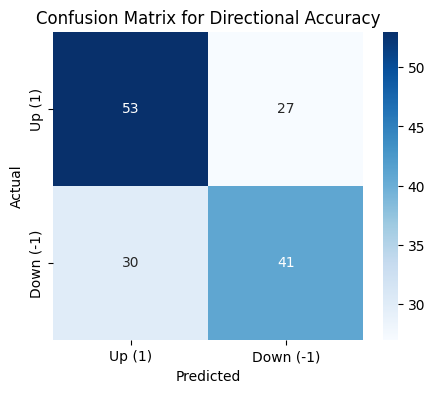

Classification Report:
               precision    recall  f1-score   support

      Up (1)       0.60      0.58      0.59        71
   Down (-1)       0.64      0.66      0.65        80

    accuracy                           0.62       151
   macro avg       0.62      0.62      0.62       151
weighted avg       0.62      0.62      0.62       151



Visualizations - MACD



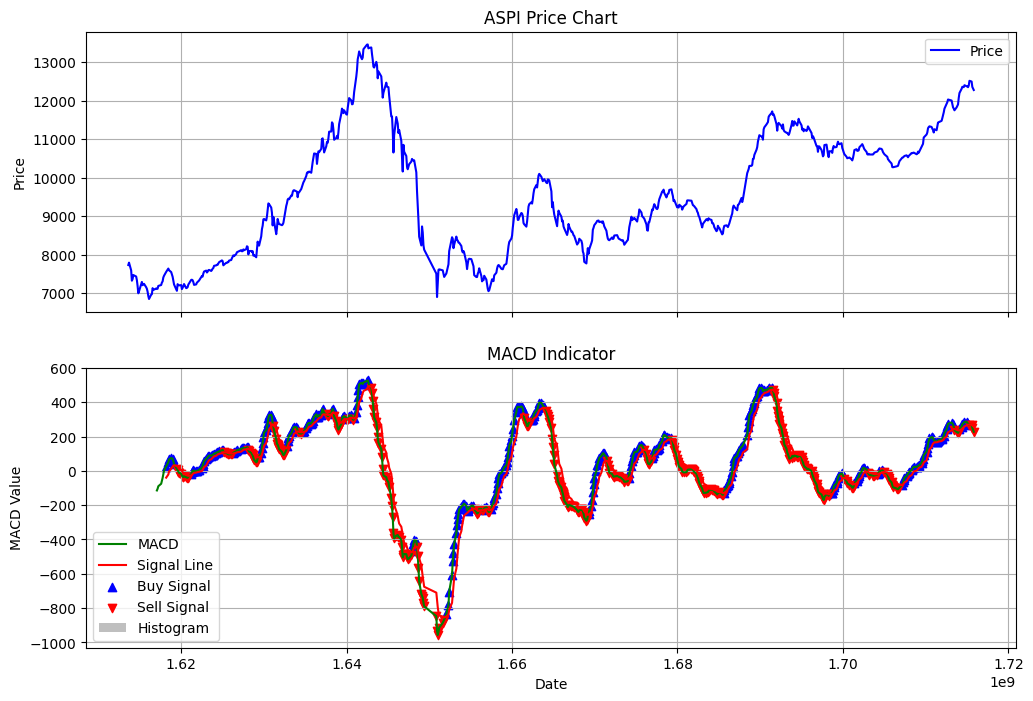

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (Price & MACD)
fig, ax = plt.subplots(2, figsize=(12, 8), sharex=True)

# --- Price Chart ---
ax[0].plot(merged_data['Date'], merged_data['Price'], label='Price', color='blue')
ax[0].set_title('ASPI Price Chart')
ax[0].set_ylabel('Price')
ax[0].legend()
ax[0].grid()

# --- MACD & Signal Line ---
ax[1].plot(merged_data['Date'], merged_data['MACD'], label='MACD', color='green')
ax[1].plot(merged_data['Date'], merged_data['MACD_Signal'], label='Signal Line', color='red')
ax[1].bar(merged_data['Date'], merged_data['MACD_Histogram'], label='Histogram', color='gray', alpha=0.5)

# Highlight Buy/Sell signals
buy_signals = merged_data[merged_data['MACD'] > merged_data['MACD_Signal']]
sell_signals = merged_data[merged_data['MACD'] < merged_data['MACD_Signal']]

ax[1].scatter(buy_signals['Date'], buy_signals['MACD'], color='blue', label='Buy Signal', marker='^', alpha=1)
ax[1].scatter(sell_signals['Date'], sell_signals['MACD'], color='red', label='Sell Signal', marker='v', alpha=1)

ax[1].set_title('MACD Indicator')
ax[1].set_ylabel('MACD Value')
ax[1].legend()
ax[1].grid()

# Show the plot
plt.xlabel('Date')
plt.show()


visualizations - Bollinger Bands

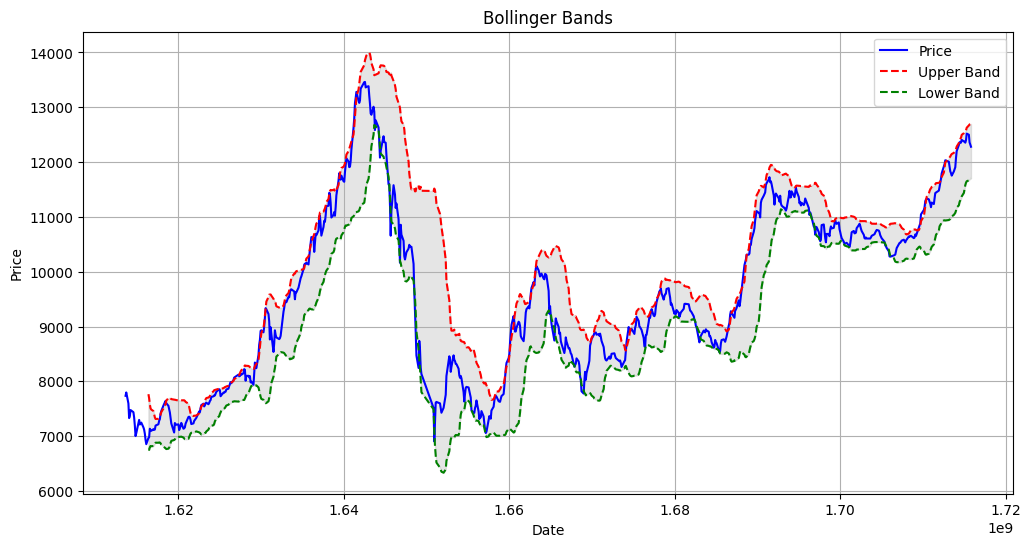

In [ ]:
import matplotlib.pyplot as plt

# Plot Price and Bollinger Bands
plt.figure(figsize=(12,6))
plt.plot(merged_data['Date'], merged_data['Price'], label='Price', color='blue')
plt.plot(merged_data['Date'], merged_data['Bollinger_High'], label='Upper Band', linestyle='dashed', color='red')
plt.plot(merged_data['Date'], merged_data['Bollinger_Low'], label='Lower Band', linestyle='dashed', color='green')
plt.fill_between(merged_data['Date'], merged_data['Bollinger_Low'], merged_data['Bollinger_High'], color='gray', alpha=0.2)
plt.legend()
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()


Tests

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Convert regression outputs into classification labels (-1, 0, 1)
y_test_classified = np.where(y_test.diff().fillna(0) > 0, 1, -1)  # 1 if price increased, -1 if decreased

# Convert y_pred to DataFrame before applying diff()
y_pred_df = pd.DataFrame(y_pred)  # Convert to DataFrame
y_pred_classified = np.where(y_pred_df.diff().fillna(0) > 0, 1, -1)  # Same for predictions

# Iterate through each target variable (20 days ahead) to calculate confusion matrices
for i in range(y_test_classified.shape[1]):
    # Confusion Matrix for each target
    cm = confusion_matrix(y_test_classified[:, i], y_pred_classified[:, i])
    print(f"Confusion Matrix for Target {i+1}:")
    print(cm)

    # Classification Report for each target
    print(f"\nClassification Report for Target {i+1}:")
    print(classification_report(y_test_classified[:, i], y_pred_classified[:, i]))


Confusion Matrix for Target 1:
[[32 39]
 [36 44]]

Classification Report for Target 1:
              precision    recall  f1-score   support

          -1       0.47      0.45      0.46        71
           1       0.53      0.55      0.54        80

    accuracy                           0.50       151
   macro avg       0.50      0.50      0.50       151
weighted avg       0.50      0.50      0.50       151

Confusion Matrix for Target 2:
[[37 35]
 [34 45]]

Classification Report for Target 2:
              precision    recall  f1-score   support

          -1       0.52      0.51      0.52        72
           1       0.56      0.57      0.57        79

    accuracy                           0.54       151
   macro avg       0.54      0.54      0.54       151
weighted avg       0.54      0.54      0.54       151

Confusion Matrix for Target 3:
[[26 46]
 [41 38]]

Classification Report for Target 3:
              precision    recall  f1-score   support

          -1       0.39      0

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions using the MultiOutputRegressor model
y_pred_reg = model.predict(X_test)  # Predict for all output variables

# Print the performance for each target
for i in range(y_pred_reg.shape[1]):  # Loop through each target variable
    print(f"\nTarget {i+1} Performance:")
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred_reg[:, i])
    mse = mean_squared_error(y_test.iloc[:, i], y_pred_reg[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred_reg[:, i])

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}")



Target 1 Performance:
Mean Absolute Error (MAE): 175.88169309370775
Mean Squared Error (MSE): 45417.47273775675
R-squared (R²): 0.8667574655071513

Target 2 Performance:
Mean Absolute Error (MAE): 188.96227278374974
Mean Squared Error (MSE): 58791.04760675686
R-squared (R²): 0.8321196592579692

Target 3 Performance:
Mean Absolute Error (MAE): 240.65068375433594
Mean Squared Error (MSE): 89565.92741120738
R-squared (R²): 0.7505689876242383

Target 4 Performance:
Mean Absolute Error (MAE): 262.3574187515639
Mean Squared Error (MSE): 110345.16993048422
R-squared (R²): 0.7019509540992339

Target 5 Performance:
Mean Absolute Error (MAE): 311.99884576218534
Mean Squared Error (MSE): 150338.0073818617
R-squared (R²): 0.6048972347669257

Target 6 Performance:
Mean Absolute Error (MAE): 310.69684379329954
Mean Squared Error (MSE): 147853.44106482252
R-squared (R²): 0.6203476328693147

Target 7 Performance:
Mean Absolute Error (MAE): 321.78902385865393
Mean Squared Error (MSE): 163656.573737746


**Model Prediction Logic**

In [ ]:
def make_prediction(input_features):
    return model.predict(input_features)  # Output is the prediction for the next day


In [ ]:
prediction = make_prediction(X_test)  # Predict for the next day
